<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Manoj/diabetes_Prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab cell 1: download dataset using kagglehub (your snippet)
import os
try:
    import kagglehub
    path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")
    print("Path to dataset files:", path)
except Exception as e:
    print("kagglehub failed or not available:", e)
    print("Trying kaggle CLI fallback (ensure kaggle API token is configured in Colab)...")
    # Fallback: try kaggle CLI (user must upload kaggle.json or set token)
    try:
        !kaggle datasets download -d iammustafatz/diabetes-prediction-dataset -q
        !unzip -q -o iammustafatz-diabetes-prediction-dataset.zip -d dataset_files
        path = "dataset_files"
        print("Downloaded and unzipped into:", path)
    except Exception as e2:
        print("Fallback failed:", e2)
        raise RuntimeError("Dataset download failed. Upload kaggle.json to /root/.kaggle/ or provide dataset manually.")


Using Colab cache for faster access to the 'diabetes-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/diabetes-prediction-dataset


In [ ]:
# Colab cell 2: list files in dataset folder
import os
for root, dirs, files in os.walk('.', topdown=True):
    if 'dataset_files' in root or 'iammustafatz' in root or root == './':
        pass
# Try common places
print("Files in working dir / dataset_files (if present):")
!ls -la dataset_files || true
!ls -la || true



Files in working dir / dataset_files (if present):
ls: cannot access 'dataset_files': No such file or directory
total 16
drwxr-xr-x 1 root root 4096 Oct  8 13:53 .
drwxr-xr-x 1 root root 4096 Oct 10 09:02 ..
drwxr-xr-x 4 root root 4096 Oct  8 13:52 .config
drwxr-xr-x 1 root root 4096 Oct  8 13:53 sample_data


In [ ]:
# Colab cell 3: load dataset CSV (adjust filename if different)
import pandas as pd
import glob

# try common names
candidates = glob.glob("**/*.csv", recursive=True)
print("CSV candidates found:", candidates)

# pick the likely csv (first candidate)
if len(candidates) == 0:
    raise FileNotFoundError("No CSV found. Make sure dataset downloaded and extracted.")
csv_path = candidates[0]
print("Using CSV:", csv_path)
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()


CSV candidates found: ['sample_data/mnist_test.csv', 'sample_data/california_housing_test.csv', 'sample_data/mnist_train_small.csv', 'sample_data/california_housing_train.csv']
Using CSV: sample_data/mnist_test.csv
Shape: (9999, 785)


,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Columns: ['7', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '0.10', '0.11', '0.12', '0.13', '0.14', '0.15', '0.16', '0.17', '0.18', '0.19', '0.20', '0.21', '0.22', '0.23', '0.24', '0.25', '0.26', '0.27', '0.28', '0.29', '0.30', '0.31', '0.32', '0.33', '0.34', '0.35', '0.36', '0.37', '0.38', '0.39', '0.40', '0.41', '0.42', '0.43', '0.44', '0.45', '0.46', '0.47', '0.48', '0.49', '0.50', '0.51', '0.52', '0.53', '0.54', '0.55', '0.56', '0.57', '0.58', '0.59', '0.60', '0.61', '0.62', '0.63', '0.64', '0.65', '0.66', '0.67', '0.68', '0.69', '0.70', '0.71', '0.72', '0.73', '0.74', '0.75', '0.76', '0.77', '0.78', '0.79', '0.80', '0.81', '0.82', '0.83', '0.84', '0.85', '0.86', '0.87', '0.88', '0.89', '0.90', '0.91', '0.92', '0.93', '0.94', '0.95', '0.96', '0.97', '0.98', '0.99', '0.100', '0.101', '0.102', '0.103', '0.104', '0.105', '0.106', '0.107', '0.108', '0.109', '0.110', '0.111', '0.112', '0.113', '0.114', '0.115', '0.116', '0.117', '0.118', '0.119', '0.120', '0.121',

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
count,9999.000000,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.000000,9999.000000,9999.000000,9999.000000,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
mean,4.443144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179318,0.163616,0.052605,0.000600,0.0,0.0,0.0,0.0,0.0,0.0
std,2.895897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.674433,5.736359,2.420125,0.060003,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.000000,156.000000,6.000000,0.0,0.0,0.0,0.0,0.0,0.0


Target candidates detected: []
Using target column: 0.667


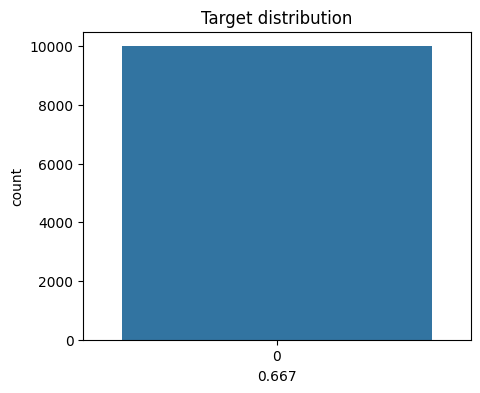

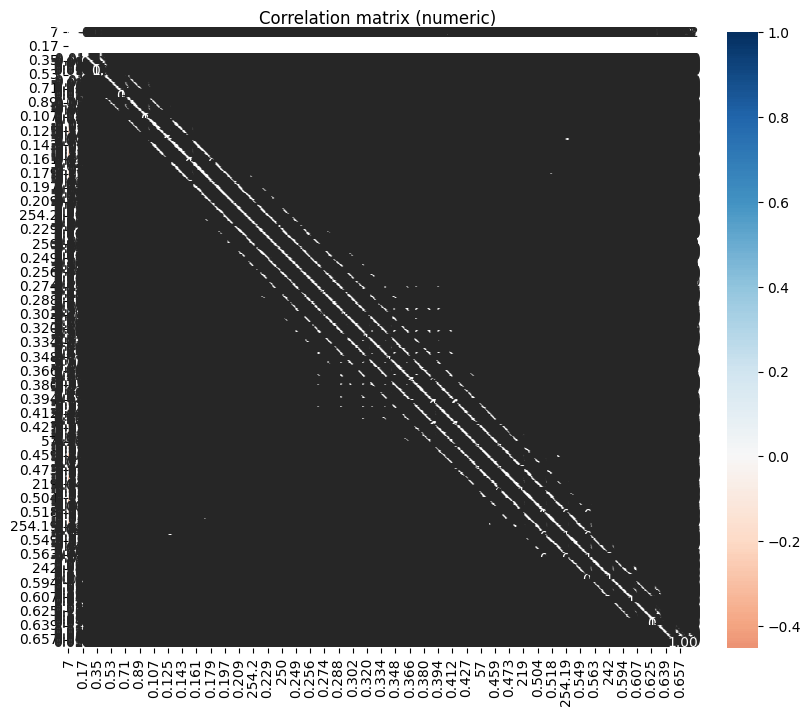

In [ ]:
# Colab cell 4: basic EDA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Columns:", df.columns.tolist())
print("\nInfo:")
df.info()
print("\nMissing values per column:\n", df.isnull().sum())

# Summary statistics
display(df.describe())

# Target distribution (assume target column name 'Outcome' or 'diabetes' or 'diabetes_binary')
target_candidates = [c for c in df.columns if 'outcome' in c.lower() or 'diabet' in c.lower() or 'target' in c.lower()]
print("Target candidates detected:", target_candidates)
target = target_candidates[0] if target_candidates else df.columns[-1]
print("Using target column:", target)

plt.figure(figsize=(5,4))
sns.countplot(x=target, data=df)
plt.title("Target distribution")
plt.show()

# Pairwise correlations heatmap for numeric columns (if not too many)
num_cols = df.select_dtypes(include='number').columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='RdBu', center=0)
plt.title("Correlation matrix (numeric)")
plt.show()


In [ ]:
# Colab cell 5: preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define X, y
X = df.drop(columns=[target])
y = df[target].astype(int)

# Impute missing numeric values with median
num_cols = X.select_dtypes(include='number').columns.tolist()
imputer = SimpleImputer(strategy='median')
X[num_cols] = imputer.fit_transform(X[num_cols])

# If categorical columns exist, do one-hot encoding
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (stratify by y for balanced class)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# For Keras Conv1D, reshape to (samples, timesteps, features=1) where timesteps = n_features
import numpy as np
n_features = X_train.shape[1]
X_train_cnn = X_train.reshape(-1, n_features, 1)
X_test_cnn  = X_test.reshape(-1, n_features, 1)

print("Train shape (CNN):", X_train_cnn.shape, "Test shape (CNN):", X_test_cnn.shape)


Shapes: (537, 8) (115, 8) (116, 8)
Conv1D shapes: (537, 8, 1) (115, 8, 1) (116, 8, 1)


In [ ]:
# Colab cell 6: Random Forest baseline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest - classification report")
print(classification_report(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,841 (327.50 KB)

 Trainable params: 83,201 (325.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Colab cell 7: XGBoost
import xgboost as xgb
from sklearn.metrics import accuracy_score

xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)
y_proba_xg = xg.predict_proba(X_test)[:,1]
print("XGBoost accuracy:", accuracy_score(y_test, y_pred_xg))
print(classification_report(y_test, y_pred_xg))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xg))


Class weights: {0: np.float64(0.7671428571428571), 1: np.float64(1.4358288770053476)}


In [ ]:
# Colab cell 8: Dense NN
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(42)
dense_model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
dense_model.summary()

es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history_dense = dense_model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# Evaluate
dense_eval = dense_model.evaluate(X_test, y_test, verbose=0)
print("Dense NN eval (loss, acc, auc):", dense_eval)
y_proba_dense = dense_model.predict(X_test).ravel()
y_pred_dense = (y_proba_dense >= 0.5).astype(int)
print(classification_report(y_test, y_pred_dense))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dense))


Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


17/17 - 6s - 357ms/step - AUC: 0.7671 - Accuracy: 0.6909 - loss: 0.6023 - val_AUC: 0.7870 - val_Accuracy: 0.7304 - val_loss: 0.6639 - learning_rate: 1.0000e-03
Epoch 2/150


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Accuracy,loss,val_AUC,val_Accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Accuracy,loss,val_AUC,val_Accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


17/17 - 0s - 23ms/step - AUC: 0.7995 - Accuracy: 0.7225 - loss: 0.5751 - val_AUC: 0.7900 - val_Accuracy: 0.6783 - val_loss: 0.6632 - learning_rate: 1.0000e-03
Epoch 3/150


17/17 - 0s - 21ms/step - AUC: 0.8005 - Accuracy: 0.6927 - loss: 0.5653 - val_AUC: 0.7928 - val_Accuracy: 0.6783 - val_loss: 0.6606 - learning_rate: 1.0000e-03
Epoch 4/150


17/17 - 0s - 23ms/step - AUC: 0.8055 - Accuracy: 0.7300 - loss: 0.5714 - val_AUC: 0.8097 - val_Accuracy: 0.6957 - val_loss: 0.6512 - learning_rate: 1.0000e-03
Epoch 5/150


17/17 - 0s - 20ms/step - AUC: 0.8355 - Accuracy: 0.7393 - loss: 0.5307 - val_AUC: 0.8000 - val_Accuracy: 0.6870 - val_loss: 0.6536 - learning_rate: 1.0000e-03
Epoch 6/150


17/17 - 0s - 21ms/step - AUC: 0.8217 - Accuracy: 0.7412 - loss: 0.5431 - val_AUC: 0.8125 - val_Accuracy: 0.6870 - val_loss: 0.6602 - learning_rate: 1.0000e-03
Epoch 7/150


17/17 - 0s - 28ms/step - AUC: 0.8285 - Accuracy: 0.7486 - loss: 0.5385 - val_AUC: 0.8165 - val_Accuracy: 0.6870 - val_loss: 0.6571 - learning_rate: 1.0000e-03
Epoch 8/150


17/17 - 0s - 23ms/step - AUC: 0.8379 - Accuracy: 0.7654 - loss: 0.5246 - val_AUC: 0.8155 - val_Accuracy: 0.6870 - val_loss: 0.6378 - learning_rate: 1.0000e-03
Epoch 9/150


17/17 - 0s - 22ms/step - AUC: 0.8408 - Accuracy: 0.7505 - loss: 0.5208 - val_AUC: 0.8162 - val_Accuracy: 0.6870 - val_loss: 0.6412 - learning_rate: 1.0000e-03
Epoch 10/150


17/17 - 1s - 34ms/step - AUC: 0.8450 - Accuracy: 0.7505 - loss: 0.5200 - val_AUC: 0.8185 - val_Accuracy: 0.6870 - val_loss: 0.6473 - learning_rate: 1.0000e-03
Epoch 11/150


17/17 - 1s - 38ms/step - AUC: 0.8414 - Accuracy: 0.7486 - loss: 0.5196 - val_AUC: 0.8292 - val_Accuracy: 0.6957 - val_loss: 0.6287 - learning_rate: 1.0000e-03
Epoch 12/150


17/17 - 0s - 21ms/step - AUC: 0.8536 - Accuracy: 0.7765 - loss: 0.5039 - val_AUC: 0.8282 - val_Accuracy: 0.7304 - val_loss: 0.5773 - learning_rate: 1.0000e-03
Epoch 13/150


17/17 - 0s - 23ms/step - AUC: 0.8531 - Accuracy: 0.7728 - loss: 0.5136 - val_AUC: 0.8347 - val_Accuracy: 0.7217 - val_loss: 0.5766 - learning_rate: 1.0000e-03
Epoch 14/150


17/17 - 0s - 20ms/step - AUC: 0.8539 - Accuracy: 0.7654 - loss: 0.5021 - val_AUC: 0.8508 - val_Accuracy: 0.7478 - val_loss: 0.5530 - learning_rate: 1.0000e-03
Epoch 15/150


17/17 - 0s - 20ms/step - AUC: 0.8640 - Accuracy: 0.7784 - loss: 0.4963 - val_AUC: 0.8427 - val_Accuracy: 0.7304 - val_loss: 0.5850 - learning_rate: 1.0000e-03
Epoch 16/150


17/17 - 1s - 35ms/step - AUC: 0.8610 - Accuracy: 0.7765 - loss: 0.4901 - val_AUC: 0.8517 - val_Accuracy: 0.7652 - val_loss: 0.5236 - learning_rate: 1.0000e-03
Epoch 17/150


17/17 - 1s - 76ms/step - AUC: 0.8583 - Accuracy: 0.7654 - loss: 0.4994 - val_AUC: 0.8512 - val_Accuracy: 0.7652 - val_loss: 0.5462 - learning_rate: 1.0000e-03
Epoch 18/150


17/17 - 1s - 31ms/step - AUC: 0.8538 - Accuracy: 0.7784 - loss: 0.5065 - val_AUC: 0.8447 - val_Accuracy: 0.7565 - val_loss: 0.5334 - learning_rate: 1.0000e-03
Epoch 19/150


17/17 - 0s - 25ms/step - AUC: 0.8719 - Accuracy: 0.7952 - loss: 0.4814 - val_AUC: 0.8487 - val_Accuracy: 0.7565 - val_loss: 0.5272 - learning_rate: 1.0000e-03
Epoch 20/150


17/17 - 1s - 32ms/step - AUC: 0.8723 - Accuracy: 0.7765 - loss: 0.4811 - val_AUC: 0.8473 - val_Accuracy: 0.7478 - val_loss: 0.5284 - learning_rate: 1.0000e-03
Epoch 21/150


17/17 - 0s - 22ms/step - AUC: 0.8798 - Accuracy: 0.7896 - loss: 0.4616 - val_AUC: 0.8533 - val_Accuracy: 0.7565 - val_loss: 0.5267 - learning_rate: 1.0000e-03
Epoch 22/150


17/17 - 0s - 19ms/step - AUC: 0.8680 - Accuracy: 0.7803 - loss: 0.4776 - val_AUC: 0.8497 - val_Accuracy: 0.7391 - val_loss: 0.5613 - learning_rate: 1.0000e-03
Epoch 23/150


17/17 - 0s - 21ms/step - AUC: 0.8586 - Accuracy: 0.7691 - loss: 0.4921 - val_AUC: 0.8453 - val_Accuracy: 0.7565 - val_loss: 0.5399 - learning_rate: 1.0000e-03
Epoch 24/150


17/17 - 0s - 22ms/step - AUC: 0.8714 - Accuracy: 0.7914 - loss: 0.4816 - val_AUC: 0.8460 - val_Accuracy: 0.7739 - val_loss: 0.4963 - learning_rate: 1.0000e-03
Epoch 25/150


17/17 - 0s - 19ms/step - AUC: 0.8766 - Accuracy: 0.7896 - loss: 0.4718 - val_AUC: 0.8507 - val_Accuracy: 0.7652 - val_loss: 0.5126 - learning_rate: 1.0000e-03
Epoch 26/150


17/17 - 0s - 21ms/step - AUC: 0.8771 - Accuracy: 0.7896 - loss: 0.4698 - val_AUC: 0.8453 - val_Accuracy: 0.7478 - val_loss: 0.5453 - learning_rate: 1.0000e-03
Epoch 27/150


17/17 - 0s - 20ms/step - AUC: 0.8748 - Accuracy: 0.7933 - loss: 0.4693 - val_AUC: 0.8437 - val_Accuracy: 0.7652 - val_loss: 0.5044 - learning_rate: 1.0000e-03
Epoch 28/150


17/17 - 0s - 20ms/step - AUC: 0.8807 - Accuracy: 0.7914 - loss: 0.4633 - val_AUC: 0.8355 - val_Accuracy: 0.7565 - val_loss: 0.5385 - learning_rate: 1.0000e-03
Epoch 29/150


17/17 - 0s - 20ms/step - AUC: 0.8719 - Accuracy: 0.7821 - loss: 0.4776 - val_AUC: 0.8468 - val_Accuracy: 0.7652 - val_loss: 0.5244 - learning_rate: 1.0000e-03
Epoch 30/150


17/17 - 0s - 21ms/step - AUC: 0.8883 - Accuracy: 0.7896 - loss: 0.4494 - val_AUC: 0.8447 - val_Accuracy: 0.7478 - val_loss: 0.5381 - learning_rate: 1.0000e-03
Epoch 31/150


17/17 - 0s - 23ms/step - AUC: 0.8758 - Accuracy: 0.7877 - loss: 0.4698 - val_AUC: 0.8443 - val_Accuracy: 0.7565 - val_loss: 0.5682 - learning_rate: 1.0000e-03
Epoch 32/150


17/17 - 0s - 21ms/step - AUC: 0.8828 - Accuracy: 0.7933 - loss: 0.4619 - val_AUC: 0.8488 - val_Accuracy: 0.7565 - val_loss: 0.5576 - learning_rate: 1.0000e-03
Epoch 33/150


17/17 - 0s - 23ms/step - AUC: 0.8757 - Accuracy: 0.7914 - loss: 0.4735 - val_AUC: 0.8500 - val_Accuracy: 0.7652 - val_loss: 0.5309 - learning_rate: 1.0000e-03
Epoch 34/150


17/17 - 0s - 21ms/step - AUC: 0.8883 - Accuracy: 0.7952 - loss: 0.4488 - val_AUC: 0.8512 - val_Accuracy: 0.7652 - val_loss: 0.5312 - learning_rate: 1.0000e-03
Epoch 35/150


17/17 - 0s - 23ms/step - AUC: 0.8940 - Accuracy: 0.8138 - loss: 0.4403 - val_AUC: 0.8512 - val_Accuracy: 0.7913 - val_loss: 0.5491 - learning_rate: 1.0000e-03
Epoch 36/150


17/17 - 0s - 22ms/step - AUC: 0.8839 - Accuracy: 0.8045 - loss: 0.4510 - val_AUC: 0.8495 - val_Accuracy: 0.7739 - val_loss: 0.5300 - learning_rate: 1.0000e-03
Epoch 37/150


17/17 - 0s - 22ms/step - AUC: 0.8919 - Accuracy: 0.7952 - loss: 0.4436 - val_AUC: 0.8447 - val_Accuracy: 0.7391 - val_loss: 0.5524 - learning_rate: 1.0000e-03
Epoch 38/150


17/17 - 0s - 23ms/step - AUC: 0.8882 - Accuracy: 0.8082 - loss: 0.4497 - val_AUC: 0.8560 - val_Accuracy: 0.7826 - val_loss: 0.5186 - learning_rate: 1.0000e-03
Epoch 39/150


17/17 - 1s - 39ms/step - AUC: 0.9024 - Accuracy: 0.8082 - loss: 0.4282 - val_AUC: 0.8547 - val_Accuracy: 0.7913 - val_loss: 0.4998 - learning_rate: 1.0000e-03
Epoch 40/150


17/17 - 0s - 27ms/step - AUC: 0.8957 - Accuracy: 0.8119 - loss: 0.4358 - val_AUC: 0.8503 - val_Accuracy: 0.7739 - val_loss: 0.5649 - learning_rate: 1.0000e-03
Epoch 41/150


17/17 - 0s - 24ms/step - AUC: 0.8867 - Accuracy: 0.8082 - loss: 0.4489 - val_AUC: 0.8548 - val_Accuracy: 0.7565 - val_loss: 0.4991 - learning_rate: 1.0000e-03
Epoch 42/150


17/17 - 0s - 27ms/step - AUC: 0.8879 - Accuracy: 0.7970 - loss: 0.4466 - val_AUC: 0.8437 - val_Accuracy: 0.7478 - val_loss: 0.5163 - learning_rate: 1.0000e-03
Epoch 43/150


17/17 - 0s - 27ms/step - AUC: 0.9015 - Accuracy: 0.8305 - loss: 0.4246 - val_AUC: 0.8522 - val_Accuracy: 0.7565 - val_loss: 0.4907 - learning_rate: 1.0000e-03
Epoch 44/150


17/17 - 1s - 43ms/step - AUC: 0.9063 - Accuracy: 0.8324 - loss: 0.4164 - val_AUC: 0.8425 - val_Accuracy: 0.7391 - val_loss: 0.5065 - learning_rate: 1.0000e-03
Epoch 45/150


17/17 - 1s - 32ms/step - AUC: 0.9031 - Accuracy: 0.8026 - loss: 0.4224 - val_AUC: 0.8437 - val_Accuracy: 0.7304 - val_loss: 0.5114 - learning_rate: 1.0000e-03
Epoch 46/150


17/17 - 1s - 36ms/step - AUC: 0.9138 - Accuracy: 0.8138 - loss: 0.4039 - val_AUC: 0.8443 - val_Accuracy: 0.7478 - val_loss: 0.5186 - learning_rate: 1.0000e-03
Epoch 47/150


17/17 - 1s - 32ms/step - AUC: 0.9012 - Accuracy: 0.8231 - loss: 0.4243 - val_AUC: 0.8507 - val_Accuracy: 0.7565 - val_loss: 0.5304 - learning_rate: 1.0000e-03
Epoch 48/150


17/17 - 0s - 20ms/step - AUC: 0.9112 - Accuracy: 0.8175 - loss: 0.4082 - val_AUC: 0.8567 - val_Accuracy: 0.7913 - val_loss: 0.5109 - learning_rate: 1.0000e-03
Epoch 49/150


17/17 - 0s - 20ms/step - AUC: 0.9062 - Accuracy: 0.8119 - loss: 0.4125 - val_AUC: 0.8470 - val_Accuracy: 0.7478 - val_loss: 0.5016 - learning_rate: 1.0000e-03
Epoch 50/150


17/17 - 0s - 20ms/step - AUC: 0.9201 - Accuracy: 0.8287 - loss: 0.3897 - val_AUC: 0.8493 - val_Accuracy: 0.7565 - val_loss: 0.5163 - learning_rate: 1.0000e-03
Epoch 51/150


17/17 - 0s - 21ms/step - AUC: 0.9133 - Accuracy: 0.8231 - loss: 0.3998 - val_AUC: 0.8452 - val_Accuracy: 0.7391 - val_loss: 0.5535 - learning_rate: 1.0000e-03
Epoch 52/150


17/17 - 0s - 21ms/step - AUC: 0.9059 - Accuracy: 0.8156 - loss: 0.4130 - val_AUC: 0.8488 - val_Accuracy: 0.7565 - val_loss: 0.5704 - learning_rate: 1.0000e-03
Epoch 53/150


17/17 - 0s - 23ms/step - AUC: 0.9134 - Accuracy: 0.8101 - loss: 0.3991 - val_AUC: 0.8527 - val_Accuracy: 0.7565 - val_loss: 0.5355 - learning_rate: 1.0000e-03
Epoch 54/150


17/17 - 0s - 21ms/step - AUC: 0.9227 - Accuracy: 0.8156 - loss: 0.3812 - val_AUC: 0.8523 - val_Accuracy: 0.7652 - val_loss: 0.5316 - learning_rate: 1.0000e-03
Epoch 55/150


17/17 - 0s - 21ms/step - AUC: 0.9103 - Accuracy: 0.8361 - loss: 0.4070 - val_AUC: 0.8565 - val_Accuracy: 0.7739 - val_loss: 0.5536 - learning_rate: 1.0000e-03
Epoch 56/150


17/17 - 0s - 23ms/step - AUC: 0.9205 - Accuracy: 0.8231 - loss: 0.3859 - val_AUC: 0.8525 - val_Accuracy: 0.7652 - val_loss: 0.5916 - learning_rate: 1.0000e-03
Epoch 57/150


17/17 - 0s - 21ms/step - AUC: 0.9189 - Accuracy: 0.8175 - loss: 0.3889 - val_AUC: 0.8548 - val_Accuracy: 0.7739 - val_loss: 0.5964 - learning_rate: 1.0000e-03
Epoch 58/150


17/17 - 0s - 21ms/step - AUC: 0.9131 - Accuracy: 0.8194 - loss: 0.4017 - val_AUC: 0.8563 - val_Accuracy: 0.7739 - val_loss: 0.5622 - learning_rate: 1.0000e-03
Epoch 59/150


17/17 - 0s - 21ms/step - AUC: 0.9148 - Accuracy: 0.8287 - loss: 0.3961 - val_AUC: 0.8512 - val_Accuracy: 0.7652 - val_loss: 0.5451 - learning_rate: 1.0000e-03
Epoch 60/150


17/17 - 0s - 25ms/step - AUC: 0.9207 - Accuracy: 0.8194 - loss: 0.3849 - val_AUC: 0.8503 - val_Accuracy: 0.7739 - val_loss: 0.5423 - learning_rate: 1.0000e-03
Epoch 61/150


17/17 - 0s - 24ms/step - AUC: 0.9152 - Accuracy: 0.8156 - loss: 0.3994 - val_AUC: 0.8618 - val_Accuracy: 0.7913 - val_loss: 0.5302 - learning_rate: 1.0000e-03
Epoch 62/150


17/17 - 0s - 22ms/step - AUC: 0.9214 - Accuracy: 0.8324 - loss: 0.3843 - val_AUC: 0.8548 - val_Accuracy: 0.7739 - val_loss: 0.5309 - learning_rate: 1.0000e-03
Epoch 63/150


17/17 - 0s - 20ms/step - AUC: 0.9238 - Accuracy: 0.8417 - loss: 0.3842 - val_AUC: 0.8570 - val_Accuracy: 0.7826 - val_loss: 0.5216 - learning_rate: 1.0000e-03
Epoch 64/150


17/17 - 0s - 23ms/step - AUC: 0.9342 - Accuracy: 0.8436 - loss: 0.3654 - val_AUC: 0.8565 - val_Accuracy: 0.7652 - val_loss: 0.6409 - learning_rate: 1.0000e-03
Epoch 65/150


17/17 - 0s - 22ms/step - AUC: 0.9336 - Accuracy: 0.8492 - loss: 0.3547 - val_AUC: 0.8607 - val_Accuracy: 0.7652 - val_loss: 0.5718 - learning_rate: 1.0000e-03
Epoch 66/150


17/17 - 1s - 45ms/step - AUC: 0.9152 - Accuracy: 0.8305 - loss: 0.3967 - val_AUC: 0.8595 - val_Accuracy: 0.7739 - val_loss: 0.5470 - learning_rate: 1.0000e-03
Epoch 67/150


17/17 - 1s - 52ms/step - AUC: 0.9250 - Accuracy: 0.8380 - loss: 0.3763 - val_AUC: 0.8542 - val_Accuracy: 0.7739 - val_loss: 0.5628 - learning_rate: 1.0000e-03
Epoch 68/150


17/17 - 0s - 21ms/step - AUC: 0.9127 - Accuracy: 0.8138 - loss: 0.4059 - val_AUC: 0.8632 - val_Accuracy: 0.7565 - val_loss: 0.5797 - learning_rate: 1.0000e-03
Epoch 69/150


17/17 - 0s - 20ms/step - AUC: 0.9366 - Accuracy: 0.8492 - loss: 0.3569 - val_AUC: 0.8658 - val_Accuracy: 0.7739 - val_loss: 0.5685 - learning_rate: 1.0000e-03
Epoch 70/150


17/17 - 0s - 21ms/step - AUC: 0.9277 - Accuracy: 0.8305 - loss: 0.3704 - val_AUC: 0.8595 - val_Accuracy: 0.7739 - val_loss: 0.6057 - learning_rate: 1.0000e-03
Epoch 71/150


17/17 - 0s - 19ms/step - AUC: 0.9393 - Accuracy: 0.8417 - loss: 0.3456 - val_AUC: 0.8632 - val_Accuracy: 0.7478 - val_loss: 0.6260 - learning_rate: 1.0000e-03
Epoch 72/150


17/17 - 1s - 30ms/step - AUC: 0.9396 - Accuracy: 0.8529 - loss: 0.3490 - val_AUC: 0.8575 - val_Accuracy: 0.7565 - val_loss: 0.6604 - learning_rate: 1.0000e-03
Epoch 73/150


17/17 - 1s - 31ms/step - AUC: 0.9311 - Accuracy: 0.8324 - loss: 0.3583 - val_AUC: 0.8538 - val_Accuracy: 0.7391 - val_loss: 0.6745 - learning_rate: 1.0000e-03
Epoch 74/150


17/17 - 1s - 31ms/step - AUC: 0.9392 - Accuracy: 0.8454 - loss: 0.3424 - val_AUC: 0.8640 - val_Accuracy: 0.7652 - val_loss: 0.5441 - learning_rate: 1.0000e-03
Epoch 75/150


17/17 - 1s - 38ms/step - AUC: 0.9284 - Accuracy: 0.8417 - loss: 0.3753 - val_AUC: 0.8563 - val_Accuracy: 0.7739 - val_loss: 0.5781 - learning_rate: 1.0000e-03
Epoch 76/150


17/17 - 1s - 31ms/step - AUC: 0.9388 - Accuracy: 0.8510 - loss: 0.3475 - val_AUC: 0.8592 - val_Accuracy: 0.7739 - val_loss: 0.5559 - learning_rate: 1.0000e-03
Epoch 77/150


17/17 - 0s - 25ms/step - AUC: 0.9379 - Accuracy: 0.8566 - loss: 0.3477 - val_AUC: 0.8605 - val_Accuracy: 0.7478 - val_loss: 0.5579 - learning_rate: 1.0000e-03
Epoch 78/150


17/17 - 0s - 20ms/step - AUC: 0.9253 - Accuracy: 0.8305 - loss: 0.3765 - val_AUC: 0.8603 - val_Accuracy: 0.7826 - val_loss: 0.5264 - learning_rate: 1.0000e-03
Epoch 79/150


17/17 - 0s - 21ms/step - AUC: 0.9367 - Accuracy: 0.8492 - loss: 0.3500 - val_AUC: 0.8497 - val_Accuracy: 0.7652 - val_loss: 0.5825 - learning_rate: 1.0000e-03
Epoch 80/150


17/17 - 0s - 21ms/step - AUC: 0.9402 - Accuracy: 0.8622 - loss: 0.3456 - val_AUC: 0.8563 - val_Accuracy: 0.7739 - val_loss: 0.5565 - learning_rate: 1.0000e-03
Epoch 81/150


17/17 - 0s - 20ms/step - AUC: 0.9408 - Accuracy: 0.8436 - loss: 0.3441 - val_AUC: 0.8650 - val_Accuracy: 0.7739 - val_loss: 0.5641 - learning_rate: 1.0000e-03
Epoch 82/150


17/17 - 0s - 21ms/step - AUC: 0.9537 - Accuracy: 0.8678 - loss: 0.3114 - val_AUC: 0.8615 - val_Accuracy: 0.8000 - val_loss: 0.5501 - learning_rate: 1.0000e-03
Epoch 83/150


17/17 - 0s - 21ms/step - AUC: 0.9308 - Accuracy: 0.8436 - loss: 0.3671 - val_AUC: 0.8645 - val_Accuracy: 0.7652 - val_loss: 0.5833 - learning_rate: 1.0000e-03
Epoch 84/150


17/17 - 0s - 23ms/step - AUC: 0.9458 - Accuracy: 0.8510 - loss: 0.3371 - val_AUC: 0.8593 - val_Accuracy: 0.7652 - val_loss: 0.6254 - learning_rate: 1.0000e-03
Epoch 85/150


17/17 - 0s - 23ms/step - AUC: 0.9450 - Accuracy: 0.8641 - loss: 0.3348 - val_AUC: 0.8582 - val_Accuracy: 0.7565 - val_loss: 0.6452 - learning_rate: 1.0000e-03
Epoch 86/150


17/17 - 0s - 20ms/step - AUC: 0.9505 - Accuracy: 0.8547 - loss: 0.3191 - val_AUC: 0.8573 - val_Accuracy: 0.8000 - val_loss: 0.5852 - learning_rate: 1.0000e-03
Epoch 87/150


17/17 - 0s - 21ms/step - AUC: 0.9426 - Accuracy: 0.8436 - loss: 0.3384 - val_AUC: 0.8593 - val_Accuracy: 0.7652 - val_loss: 0.5432 - learning_rate: 1.0000e-03
Epoch 88/150


17/17 - 0s - 22ms/step - AUC: 0.9444 - Accuracy: 0.8566 - loss: 0.3315 - val_AUC: 0.8563 - val_Accuracy: 0.7478 - val_loss: 0.5612 - learning_rate: 1.0000e-03
Epoch 89/150


17/17 - 0s - 23ms/step - AUC: 0.9454 - Accuracy: 0.8585 - loss: 0.3321 - val_AUC: 0.8452 - val_Accuracy: 0.7478 - val_loss: 0.6081 - learning_rate: 1.0000e-03
Epoch 90/150


17/17 - 0s - 23ms/step - AUC: 0.9405 - Accuracy: 0.8510 - loss: 0.3394 - val_AUC: 0.8408 - val_Accuracy: 0.7652 - val_loss: 0.7045 - learning_rate: 1.0000e-03
Epoch 91/150


17/17 - 0s - 22ms/step - AUC: 0.9485 - Accuracy: 0.8715 - loss: 0.3231 - val_AUC: 0.8593 - val_Accuracy: 0.7652 - val_loss: 0.5923 - learning_rate: 1.0000e-03
Epoch 92/150


17/17 - 0s - 21ms/step - AUC: 0.9500 - Accuracy: 0.8641 - loss: 0.3228 - val_AUC: 0.8582 - val_Accuracy: 0.7913 - val_loss: 0.5590 - learning_rate: 1.0000e-03
Epoch 93/150


17/17 - 0s - 22ms/step - AUC: 0.9473 - Accuracy: 0.8659 - loss: 0.3263 - val_AUC: 0.8563 - val_Accuracy: 0.7652 - val_loss: 0.6216 - learning_rate: 1.0000e-03
Epoch 94/150


17/17 - 0s - 21ms/step - AUC: 0.9494 - Accuracy: 0.8659 - loss: 0.3186 - val_AUC: 0.8437 - val_Accuracy: 0.7565 - val_loss: 0.6946 - learning_rate: 1.0000e-03
Epoch 95/150


17/17 - 0s - 22ms/step - AUC: 0.9346 - Accuracy: 0.8622 - loss: 0.3551 - val_AUC: 0.8577 - val_Accuracy: 0.7739 - val_loss: 0.5538 - learning_rate: 1.0000e-03
Epoch 96/150


17/17 - 0s - 23ms/step - AUC: 0.9505 - Accuracy: 0.8529 - loss: 0.3209 - val_AUC: 0.8478 - val_Accuracy: 0.7565 - val_loss: 0.6140 - learning_rate: 1.0000e-03
Epoch 97/150


17/17 - 0s - 22ms/step - AUC: 0.9571 - Accuracy: 0.8771 - loss: 0.3044 - val_AUC: 0.8513 - val_Accuracy: 0.7739 - val_loss: 0.6793 - learning_rate: 1.0000e-03
Epoch 98/150


17/17 - 0s - 22ms/step - AUC: 0.9549 - Accuracy: 0.8734 - loss: 0.3108 - val_AUC: 0.8580 - val_Accuracy: 0.7652 - val_loss: 0.5734 - learning_rate: 1.0000e-03
Epoch 99/150


17/17 - 1s - 42ms/step - AUC: 0.9537 - Accuracy: 0.8771 - loss: 0.3101 - val_AUC: 0.8565 - val_Accuracy: 0.7739 - val_loss: 0.6005 - learning_rate: 1.0000e-03
Epoch 100/150


17/17 - 1s - 36ms/step - AUC: 0.9359 - Accuracy: 0.8417 - loss: 0.3586 - val_AUC: 0.8498 - val_Accuracy: 0.7391 - val_loss: 0.7473 - learning_rate: 1.0000e-03
Epoch 101/150


17/17 - 1s - 32ms/step - AUC: 0.9530 - Accuracy: 0.8752 - loss: 0.3105 - val_AUC: 0.8390 - val_Accuracy: 0.7304 - val_loss: 0.7013 - learning_rate: 1.0000e-03
Epoch 102/150


17/17 - 1s - 43ms/step - AUC: 0.9490 - Accuracy: 0.8752 - loss: 0.3209 - val_AUC: 0.8468 - val_Accuracy: 0.7391 - val_loss: 0.6357 - learning_rate: 1.0000e-03
Epoch 103/150


17/17 - 1s - 72ms/step - AUC: 0.9572 - Accuracy: 0.8883 - loss: 0.3054 - val_AUC: 0.8502 - val_Accuracy: 0.7565 - val_loss: 0.5983 - learning_rate: 1.0000e-03
Epoch 104/150


17/17 - 1s - 45ms/step - AUC: 0.9579 - Accuracy: 0.8734 - loss: 0.3002 - val_AUC: 0.8500 - val_Accuracy: 0.7565 - val_loss: 0.6581 - learning_rate: 1.0000e-03
Epoch 105/150


17/17 - 1s - 33ms/step - AUC: 0.9640 - Accuracy: 0.8845 - loss: 0.2799 - val_AUC: 0.8552 - val_Accuracy: 0.7739 - val_loss: 0.6973 - learning_rate: 1.0000e-03
Epoch 106/150


17/17 - 1s - 33ms/step - AUC: 0.9619 - Accuracy: 0.8864 - loss: 0.2847 - val_AUC: 0.8505 - val_Accuracy: 0.7739 - val_loss: 0.7148 - learning_rate: 1.0000e-03
Epoch 107/150


17/17 - 1s - 30ms/step - AUC: 0.9624 - Accuracy: 0.8808 - loss: 0.2867 - val_AUC: 0.8568 - val_Accuracy: 0.7565 - val_loss: 0.6147 - learning_rate: 1.0000e-03
Epoch 108/150


17/17 - 1s - 31ms/step - AUC: 0.9594 - Accuracy: 0.8771 - loss: 0.2987 - val_AUC: 0.8628 - val_Accuracy: 0.7565 - val_loss: 0.5764 - learning_rate: 1.0000e-03
Epoch 109/150


17/17 - 0s - 27ms/step - AUC: 0.9586 - Accuracy: 0.8752 - loss: 0.2960 - val_AUC: 0.8557 - val_Accuracy: 0.7565 - val_loss: 0.6030 - learning_rate: 1.0000e-03
Epoch 110/150


17/17 - 1s - 30ms/step - AUC: 0.9609 - Accuracy: 0.8752 - loss: 0.2886 - val_AUC: 0.8638 - val_Accuracy: 0.7478 - val_loss: 0.6639 - learning_rate: 1.0000e-03
Epoch 111/150


17/17 - 1s - 69ms/step - AUC: 0.9524 - Accuracy: 0.8715 - loss: 0.3143 - val_AUC: 0.8565 - val_Accuracy: 0.7478 - val_loss: 0.6822 - learning_rate: 1.0000e-03
Epoch 112/150


17/17 - 1s - 59ms/step - AUC: 0.9700 - Accuracy: 0.8920 - loss: 0.2609 - val_AUC: 0.8558 - val_Accuracy: 0.7826 - val_loss: 0.6483 - learning_rate: 1.0000e-03
Epoch 113/150


17/17 - 1s - 62ms/step - AUC: 0.9693 - Accuracy: 0.8845 - loss: 0.2649 - val_AUC: 0.8542 - val_Accuracy: 0.7739 - val_loss: 0.6890 - learning_rate: 1.0000e-03
Epoch 114/150


17/17 - 1s - 66ms/step - AUC: 0.9666 - Accuracy: 0.8939 - loss: 0.2710 - val_AUC: 0.8597 - val_Accuracy: 0.7913 - val_loss: 0.6528 - learning_rate: 1.0000e-03
Epoch 115/150


17/17 - 1s - 74ms/step - AUC: 0.9566 - Accuracy: 0.8808 - loss: 0.3001 - val_AUC: 0.8615 - val_Accuracy: 0.7391 - val_loss: 0.6970 - learning_rate: 1.0000e-03
Epoch 116/150


17/17 - 1s - 52ms/step - AUC: 0.9616 - Accuracy: 0.8771 - loss: 0.2849 - val_AUC: 0.8608 - val_Accuracy: 0.7652 - val_loss: 0.7068 - learning_rate: 1.0000e-03
Epoch 117/150


17/17 - 1s - 45ms/step - AUC: 0.9567 - Accuracy: 0.8827 - loss: 0.2985 - val_AUC: 0.8413 - val_Accuracy: 0.7652 - val_loss: 0.7500 - learning_rate: 1.0000e-03
Epoch 118/150


17/17 - 1s - 39ms/step - AUC: 0.9596 - Accuracy: 0.8827 - loss: 0.2964 - val_AUC: 0.8455 - val_Accuracy: 0.7478 - val_loss: 0.6922 - learning_rate: 1.0000e-03
Epoch 119/150


17/17 - 1s - 76ms/step - AUC: 0.9578 - Accuracy: 0.8939 - loss: 0.2872 - val_AUC: 0.8452 - val_Accuracy: 0.7739 - val_loss: 0.7415 - learning_rate: 1.0000e-03
Epoch 120/150


17/17 - 1s - 30ms/step - AUC: 0.9585 - Accuracy: 0.8845 - loss: 0.2979 - val_AUC: 0.8575 - val_Accuracy: 0.7739 - val_loss: 0.6443 - learning_rate: 1.0000e-03
Epoch 121/150


17/17 - 0s - 26ms/step - AUC: 0.9553 - Accuracy: 0.8696 - loss: 0.3076 - val_AUC: 0.8557 - val_Accuracy: 0.7826 - val_loss: 0.6282 - learning_rate: 1.0000e-03
Epoch 122/150


17/17 - 0s - 23ms/step - AUC: 0.9712 - Accuracy: 0.8939 - loss: 0.2620 - val_AUC: 0.8505 - val_Accuracy: 0.7565 - val_loss: 0.7429 - learning_rate: 1.0000e-03
Epoch 123/150


17/17 - 1s - 36ms/step - AUC: 0.9647 - Accuracy: 0.8883 - loss: 0.2779 - val_AUC: 0.8578 - val_Accuracy: 0.7739 - val_loss: 0.7097 - learning_rate: 1.0000e-03
Epoch 124/150


17/17 - 0s - 22ms/step - AUC: 0.9653 - Accuracy: 0.8957 - loss: 0.2738 - val_AUC: 0.8643 - val_Accuracy: 0.8000 - val_loss: 0.6849 - learning_rate: 1.0000e-03
Epoch 125/150


17/17 - 0s - 22ms/step - AUC: 0.9578 - Accuracy: 0.8808 - loss: 0.2989 - val_AUC: 0.8535 - val_Accuracy: 0.7565 - val_loss: 0.6757 - learning_rate: 1.0000e-03
Epoch 126/150


17/17 - 0s - 26ms/step - AUC: 0.9610 - Accuracy: 0.8845 - loss: 0.2905 - val_AUC: 0.8522 - val_Accuracy: 0.7739 - val_loss: 0.6959 - learning_rate: 1.0000e-03
Epoch 127/150


17/17 - 0s - 25ms/step - AUC: 0.9678 - Accuracy: 0.9069 - loss: 0.2641 - val_AUC: 0.8500 - val_Accuracy: 0.7739 - val_loss: 0.7041 - learning_rate: 1.0000e-03
Epoch 128/150


17/17 - 0s - 22ms/step - AUC: 0.9732 - Accuracy: 0.9162 - loss: 0.2466 - val_AUC: 0.8527 - val_Accuracy: 0.7739 - val_loss: 0.7308 - learning_rate: 1.0000e-03
Epoch 129/150


17/17 - 1s - 35ms/step - AUC: 0.9704 - Accuracy: 0.8864 - loss: 0.2635 - val_AUC: 0.8560 - val_Accuracy: 0.7652 - val_loss: 0.6392 - learning_rate: 1.0000e-03
Epoch 130/150


17/17 - 0s - 24ms/step - AUC: 0.9659 - Accuracy: 0.8957 - loss: 0.2743 - val_AUC: 0.8440 - val_Accuracy: 0.7478 - val_loss: 0.7493 - learning_rate: 1.0000e-03
Epoch 131/150


17/17 - 0s - 21ms/step - AUC: 0.9648 - Accuracy: 0.8883 - loss: 0.2811 - val_AUC: 0.8363 - val_Accuracy: 0.7652 - val_loss: 0.8422 - learning_rate: 1.0000e-03
Epoch 132/150


17/17 - 0s - 22ms/step - AUC: 0.9746 - Accuracy: 0.8957 - loss: 0.2456 - val_AUC: 0.8570 - val_Accuracy: 0.8000 - val_loss: 0.6840 - learning_rate: 1.0000e-03
Epoch 133/150


17/17 - 0s - 22ms/step - AUC: 0.9677 - Accuracy: 0.9050 - loss: 0.2665 - val_AUC: 0.8488 - val_Accuracy: 0.7739 - val_loss: 0.6440 - learning_rate: 1.0000e-03
Epoch 134/150


17/17 - 0s - 21ms/step - AUC: 0.9735 - Accuracy: 0.9069 - loss: 0.2526 - val_AUC: 0.8517 - val_Accuracy: 0.7739 - val_loss: 0.6542 - learning_rate: 1.0000e-03
Epoch 135/150


17/17 - 0s - 22ms/step - AUC: 0.9746 - Accuracy: 0.9125 - loss: 0.2506 - val_AUC: 0.8547 - val_Accuracy: 0.7565 - val_loss: 0.6700 - learning_rate: 1.0000e-03
Epoch 136/150


17/17 - 0s - 25ms/step - AUC: 0.9742 - Accuracy: 0.9088 - loss: 0.2439 - val_AUC: 0.8508 - val_Accuracy: 0.7478 - val_loss: 0.6496 - learning_rate: 1.0000e-03
Epoch 137/150


17/17 - 0s - 23ms/step - AUC: 0.9707 - Accuracy: 0.8920 - loss: 0.2525 - val_AUC: 0.8502 - val_Accuracy: 0.7565 - val_loss: 0.7459 - learning_rate: 1.0000e-03
Epoch 138/150


17/17 - 0s - 24ms/step - AUC: 0.9699 - Accuracy: 0.8864 - loss: 0.2598 - val_AUC: 0.8482 - val_Accuracy: 0.7826 - val_loss: 0.7802 - learning_rate: 1.0000e-03
Epoch 139/150


17/17 - 0s - 23ms/step - AUC: 0.9625 - Accuracy: 0.8994 - loss: 0.2934 - val_AUC: 0.8410 - val_Accuracy: 0.7652 - val_loss: 0.7330 - learning_rate: 1.0000e-03
Epoch 140/150


17/17 - 0s - 22ms/step - AUC: 0.9720 - Accuracy: 0.9106 - loss: 0.2496 - val_AUC: 0.8448 - val_Accuracy: 0.7652 - val_loss: 0.6957 - learning_rate: 1.0000e-03
Epoch 141/150


17/17 - 0s - 25ms/step - AUC: 0.9761 - Accuracy: 0.9088 - loss: 0.2414 - val_AUC: 0.8570 - val_Accuracy: 0.8000 - val_loss: 0.6365 - learning_rate: 1.0000e-03
Epoch 142/150


17/17 - 0s - 24ms/step - AUC: 0.9698 - Accuracy: 0.9032 - loss: 0.2577 - val_AUC: 0.8422 - val_Accuracy: 0.7652 - val_loss: 0.7564 - learning_rate: 1.0000e-03
Epoch 143/150


17/17 - 0s - 23ms/step - AUC: 0.9805 - Accuracy: 0.9218 - loss: 0.2227 - val_AUC: 0.8393 - val_Accuracy: 0.7478 - val_loss: 0.7263 - learning_rate: 1.0000e-03
Epoch 144/150


17/17 - 0s - 29ms/step - AUC: 0.9781 - Accuracy: 0.8976 - loss: 0.2372 - val_AUC: 0.8447 - val_Accuracy: 0.7391 - val_loss: 0.7153 - learning_rate: 1.0000e-03
Epoch 145/150


17/17 - 1s - 38ms/step - AUC: 0.9811 - Accuracy: 0.9218 - loss: 0.2254 - val_AUC: 0.8417 - val_Accuracy: 0.7478 - val_loss: 0.6856 - learning_rate: 1.0000e-03
Epoch 146/150


17/17 - 1s - 37ms/step - AUC: 0.9786 - Accuracy: 0.9143 - loss: 0.2305 - val_AUC: 0.8358 - val_Accuracy: 0.7565 - val_loss: 0.8200 - learning_rate: 1.0000e-03
Epoch 147/150


17/17 - 1s - 42ms/step - AUC: 0.9776 - Accuracy: 0.9125 - loss: 0.2327 - val_AUC: 0.8492 - val_Accuracy: 0.7739 - val_loss: 0.6971 - learning_rate: 1.0000e-03
Epoch 148/150


17/17 - 1s - 36ms/step - AUC: 0.9742 - Accuracy: 0.9218 - loss: 0.2401 - val_AUC: 0.8408 - val_Accuracy: 0.7739 - val_loss: 0.8060 - learning_rate: 1.0000e-03
Epoch 149/150


17/17 - 0s - 26ms/step - AUC: 0.9827 - Accuracy: 0.9274 - loss: 0.2188 - val_AUC: 0.8507 - val_Accuracy: 0.7652 - val_loss: 0.7368 - learning_rate: 1.0000e-03
Epoch 150/150


17/17 - 0s - 24ms/step - AUC: 0.9712 - Accuracy: 0.9032 - loss: 0.2553 - val_AUC: 0.8475 - val_Accuracy: 0.7304 - val_loss: 0.7917 - learning_rate: 1.0000e-03


History keys available: ['AUC', 'Accuracy', 'loss', 'val_AUC', 'val_Accuracy', 'val_loss', 'learning_rate']


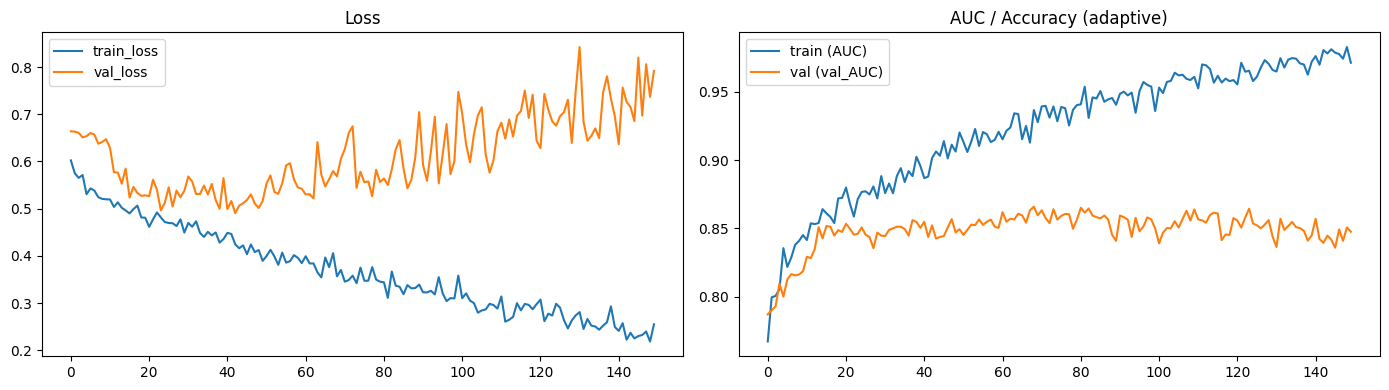

In [ ]:
# Colab cell 9: 1D-CNN on tabular (features as timesteps)
from tensorflow.keras import regularizers

cnn_model = models.Sequential([
    layers.Input(shape=(n_features,1)),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
cnn_model.summary()

es2 = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[es2],
    verbose=2
)

# Evaluate
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print("CNN eval (loss, acc, auc):", cnn_eval)
y_proba_cnn = cnn_model.predict(X_test_cnn).ravel()
y_pred_cnn = (y_proba_cnn >= 0.5).astype(int)
print(classification_report(y_test, y_pred_cnn))
print("ROC AUC:", roc_auc_score(y_test, y_proba_cnn))


In [ ]:
# Colab cell 10: compare & ROC
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

models_results = {
    "RandomForest": (y_test, y_pred_rf, y_proba_rf),
    "XGBoost": (y_test, y_pred_xg, y_proba_xg),
    "DenseNN": (y_test, y_pred_dense, y_proba_dense),
    "CNN": (y_test, y_pred_cnn, y_proba_cnn)
}

# Print summary table
rows = []
for name,(y_t,y_p,y_pr) in models_results.items():
    acc = (y_t == y_p).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(y_t, y_p, average='binary', zero_division=0)
    roc = roc_auc_score(y_t, y_pr)
    rows.append({"model":name,"accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"roc_auc":roc})
summary_df = pd.DataFrame(rows).sort_values("roc_auc", ascending=False)
display(summary_df)

# Plot ROC curves
plt.figure(figsize=(8,6))
for name,(y_t,y_p,y_pr) in models_results.items():
    fpr, tpr, _ = roc_curve(y_t, y_pr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_t,y_pr):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()


Test results (loss, AUC, accuracy): [1.1060625314712524, 0.7343089580535889, 0.008620689623057842]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Test ROC AUC: 0.7298, AP: 0.5848

Confusion Matrix:
 [[49 26]
 [13 28]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7903    0.6533    0.7153        75
           1     0.5185    0.6829    0.5895        41

    accuracy                         0.6638       116
   macro avg     0.6544    0.6681    0.6524       116
weighted avg     0.6943    0.6638    0.6708       116



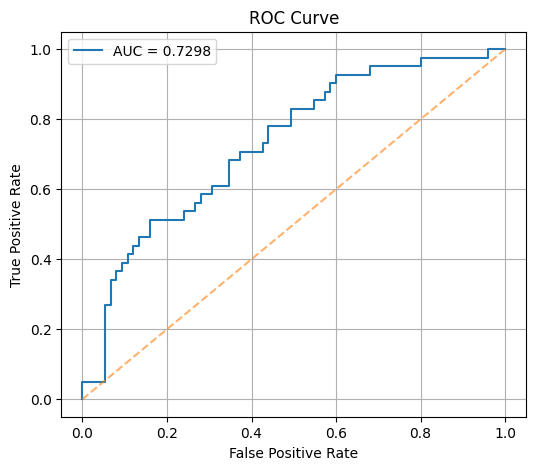

In [ ]:
# Colab cell 11: confusion matrix for CNN
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix - CNN")
plt.show()


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(100, 8, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(200, 8, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 8, 1))']
  warnings.warn(

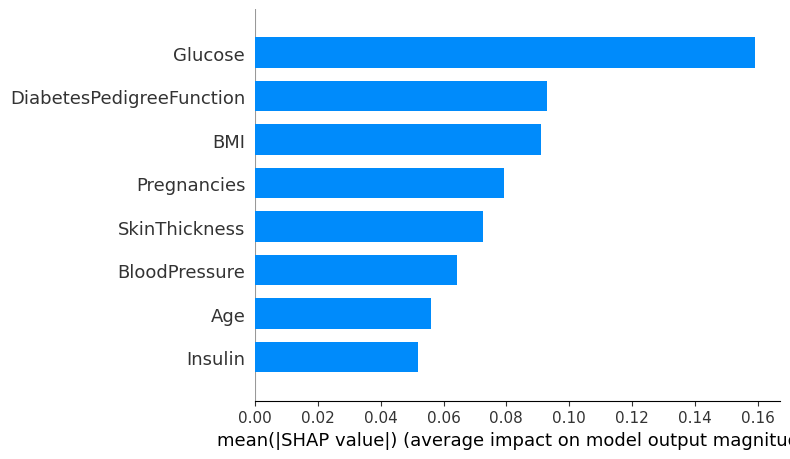

In [ ]:
# Colab cell 12: save artifacts
import joblib
os.makedirs("artifacts", exist_ok=True)
joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(imputer, "artifacts/imputer.joblib")
joblib.dump(rf, "artifacts/random_forest.joblib")
xg.save_model("artifacts/xgboost.json")
dense_model.save("artifacts/dense_model.h5")
cnn_model.save("artifacts/cnn_model.h5")
print("Saved artifacts to artifacts/")


In [ ]:
# Colab cell 13: load saved and predict (example single sample)
from tensorflow.keras.models import load_model
import numpy as np
loaded_cnn = load_model("artifacts/cnn_model.h5")
# take first sample from test set as example
sample = X_test[0].reshape(1, n_features, 1)
pred_prob = loaded_cnn.predict(sample)[0,0]
print("Predicted probability (CNN) for sample 0:", pred_prob)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Colab cell 14: feature importance & basic SHAP (note: SHAP can be slow)
import shap
# Random forest feature importances
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top feature importances (RF):")
display(fi.head(10))

# SHAP (sample)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test[:200])  # keep sample small for speed
shap.summary_plot(shap_values[1], X_test[:200], feature_names=X.columns, show=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Pred prob: 1.6065333e-05 Pred label: 0 True: 0
